In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import warnings
import os

from datetime import datetime as dt
from sklearn.metrics import r2_score,mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
global scaler
scaler = MinMaxScaler()

from IPython.core.display import HTML
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [0]:
def get_data():
    train = pd.read_csv('https://s3.us-east-2.amazonaws.com/final-project-dataset/train.csv')
    test = pd.read_csv('https://s3.us-east-2.amazonaws.com/final-project-dataset/test.csv')
    return train, test

In [0]:
def preprocessing_data(train,test):
    global categoricalFeatureNames,numericalFeatureNames
    
    #Combining Test and Train Frames
    data = train.append(test)
    data.reset_index(inplace=True)
    data.drop('index',inplace=True,axis=1)
    
    #Deriving Time Series Columns from datetime field
    data["date"] = data.datetime.apply(lambda x : x.split()[0])
    data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
    data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
    data["weekday"] = data.date.apply(lambda dateString : dt.strptime(dateString,"%Y-%m-%d").weekday())
    data["month"] = data.date.apply(lambda dateString : dt.strptime(dateString,"%Y-%m-%d").month)
    
    #Predicting Missing Wind Values using RF Regressor
    dataWind0 = data[data["windspeed"]==0]
    dataWindNot0 = data[data["windspeed"]!=0]
    rfModel_wind = RandomForestRegressor()
    windColumns = ["season","weather","humidity","month","temp","year","atemp"]
    rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])
    wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
    dataWind0["windspeed"] = wind0Values
    data = dataWindNot0.append(dataWind0)
    data.reset_index(inplace=True)
    data.drop('index',inplace=True,axis=1)
    
    #Designating Categorical Features from numeric columns
    categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
    numericalFeatureNames = ["atemp","humidity","windspeed"]
    dropFeatures = ["casual","datetime","date","registered","temp"]
    
    for var in categoricalFeatureNames:
        data[var] = data[var].astype("category")
    
    dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
    dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
    
    dataTrain  = dataTrain.drop(dropFeatures,axis=1)
    dataTest  = dataTest.drop(dropFeatures,axis=1)
    dataTest = dataTest.drop('count',axis=1)
    
    return dataTrain,dataTest

In [0]:
error_metric = pd.DataFrame({'Training RMSLE': [],
                             'Training R^2': [],
                             'Testing RMSLE':[],
                             'Testing R^2' : []})

def model_stats(model, model_name, X_train, Y_train, X_test, Y_test):
    global error_metric
    train_data_predictions = model.predict(X_train)
    test_data_predictions = model.predict(X_test)

    # RMSLE
    model_rmsle_train = np.sqrt(mean_squared_log_error(Y_train, train_data_predictions))
    model_rmsle_test = np.sqrt(mean_squared_log_error(Y_test, test_data_predictions))

    # R-Squared
    model_r2_train = r2_score(Y_train, train_data_predictions)
    model_r2_test = r2_score(Y_test, test_data_predictions)

    df_local = pd.DataFrame({'Model': [model_name],
                             'Training RMSLE': [model_rmsle_train],
                             'Training R^2': [model_r2_train],
                             'Testing RMSLE':[model_rmsle_test],
                             'Testing R^2' : [model_r2_test]})

    error_metric = pd.concat([error_metric, df_local])

In [0]:
df_train, df_test = get_data()
processed_train, processed_test = preprocessing_data(df_train, df_test)

X = processed_train.drop('count', axis=1)
Y = processed_train['count']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, shuffle=False)

# GRID SEARCH CV FOR TUNING :

In [0]:
param_grid_rf = {'n_estimators':[5,20,100], 'max_depth':[5,10,50], 'oob_score':[True,False]}

grid_rf = GridSearchCV(RandomForestRegressor(), param_grid = param_grid_rf, n_jobs=-1, cv=3, refit=True, verbose=4)

In [7]:
grid_rf.fit(X_train,Y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] max_depth=5, n_estimators=5, oob_score=True .....................
[CV] max_depth=5, n_estimators=5, oob_score=True .....................
[CV]  max_depth=5, n_estimators=5, oob_score=True, score=0.24724311200925475, total=   0.1s
[CV]  max_depth=5, n_estimators=5, oob_score=True, score=0.5878555093430993, total=   0.1s
[CV] max_depth=5, n_estimators=5, oob_score=True .....................
[CV] max_depth=5, n_estimators=5, oob_score=False ....................
[CV]  max_depth=5, n_estimators=5, oob_score=True, score=0.2679574412277258, total=   0.1s
[CV] max_depth=5, n_estimators=5, oob_score=False ....................
[CV]  max_depth=5, n_estimators=5, oob_score=False, score=0.24582685041398622, total=   0.1s
[CV] max_depth=5, n_estimators=20, oob_score=True ....................
[CV]  max_depth=5, n_estimators=5, oob_score=False, score=0.5688209502500443, total=   0.1s
[CV] max_depth=5, n_estimators=5, oob_score=False ....

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.2s


[CV]  max_depth=50, n_estimators=5, oob_score=False, score=0.8568197066759603, total=   0.1s
[CV] max_depth=50, n_estimators=5, oob_score=False ...................
[CV]  max_depth=50, n_estimators=5, oob_score=False, score=0.497526284846954, total=   0.1s
[CV] max_depth=50, n_estimators=20, oob_score=True ...................
[CV]  max_depth=10, n_estimators=100, oob_score=False, score=0.8628236328276702, total=   1.6s
[CV] max_depth=10, n_estimators=100, oob_score=False .................
[CV]  max_depth=50, n_estimators=20, oob_score=True, score=0.3485366947229911, total=   0.5s
[CV] max_depth=50, n_estimators=20, oob_score=True ...................
[CV]  max_depth=50, n_estimators=20, oob_score=True, score=0.8781274015096346, total=   0.5s
[CV] max_depth=50, n_estimators=20, oob_score=True ...................
[CV]  max_depth=50, n_estimators=20, oob_score=True, score=0.5242327368860931, total=   0.5s
[CV] max_depth=50, n_estimators=20, oob_score=False ..................
[CV]  max_depth

[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   20.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [5, 20, 100], 'max_depth': [5, 10, 50], 'oob_score': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=4)

In [8]:
grid_rf.best_params_

{'max_depth': 50, 'n_estimators': 20, 'oob_score': False}

In [0]:
model_stats(grid_rf,'Tuned RF Model', X_train, Y_train, X_test, Y_test)

In [10]:
error_metric

,Model,Testing RMSLE,Testing R^2,Training RMSLE,Training R^2
0,Tuned RF Model,0.361795,0.862357,0.164994,0.990561


In [0]:
#Scaling the data and checking with Tuned Model
yte = np.array(Y_test).reshape(len(Y_test),1)
ytr = np.array(Y_train).reshape(len(Y_train),1)

X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled = scaler.fit_transform(X_train)

Y_train_scaled = scaler.fit_transform(ytr).ravel()
Y_test_scaled = scaler.fit_transform(yte).ravel()

In [0]:
tuned_rf = RandomForestRegressor(n_estimators = 100, max_depth = 50, oob_score = False, n_jobs = -1)
tuned_rf.fit(X_train_scaled,Y_train_scaled)
model_stats(tuned_rf,'Scaled & Tuned RF', X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled)

In [13]:
error_metric

,Model,Testing RMSLE,Testing R^2,Training RMSLE,Training R^2
0,Tuned RF Model,0.361795,0.862357,0.164994,0.990561
0,Scaled & Tuned RF,0.100787,0.591306,0.011758,0.992381


# FEATURE SELECTION

## BORUTA

In [14]:
!pip install Boruta

In [0]:
from boruta import BorutaPy

In [16]:
X_Boruta = X_train.values
Y_Boruta = Y_train.values
Y_Boruta = Y_Boruta.ravel()

tuned_model_boruta = RandomForestRegressor(n_estimators = 100, max_depth = 50, oob_score = False, n_jobs = -1)

# define Boruta feature selection method
feat_selector = BorutaPy(tuned_model_boruta, n_estimators='auto', verbose=5, random_state=1, max_iter=50)

# find all relevant features
feat_selector.fit(X_Boruta, Y_Boruta)

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	8
Tentative: 	2
Rejected: 	1
Iteration: 	9 / 50
Confirmed: 	8
Tentative: 	2
Rejected: 	1
Iteration: 	10 / 50
Confirmed: 	8
Tentative: 	2
Rejected: 	1
Iteration: 	11 / 50
Confirmed: 	8
Tentative: 	2
Rejected: 	1
Iteration: 	12 / 50
Confirmed: 	8
Tentative: 	2
Rejected: 	1
Iteration: 	13 / 50
Confirmed: 	8
Tentative: 	2
Rejected: 	1
Iteration: 	14 / 50
Confirmed: 	8
Tentative: 	2
Rejected: 	1
Iteration: 	15 / 50
Confirmed: 	8
Tentative: 	2
Rejected: 	1
Iteration: 	16 / 50
Confirmed: 	8
Tentative: 	2
Rejected: 	1
Iteration: 	17 / 50
Confir

array([1, 4, 1, 3, 1, 2, 1, 1, 1, 1, 1])

In [17]:
boruta_feature_ranking = zip(list(X_train.columns),list(feat_selector.ranking_))
boruta_feature_ranking = set(boruta_feature_ranking)
print(boruta_feature_ranking)

{('hour', 1), ('weather', 1), ('year', 1), ('month', 1), ('weekday', 1), ('holiday', 4), ('season', 3), ('windspeed', 2), ('workingday', 1), ('atemp', 1), ('humidity', 1)}


In [0]:
boruta_features = ['weather','humidity','year','hour','month','workingday','season','atemp','weekday']

X_train_Boruta = X_train[boruta_features]
X_test_Boruta = X_test[boruta_features]

In [0]:
tuned_model = RandomForestRegressor(n_estimators = 100, max_depth = 50, oob_score = False, n_jobs = -1)
tuned_model.fit(X_train_Boruta,Y_train)
model_stats(tuned_model,'Boruta Features RF', X_train_Boruta, Y_train, X_test_Boruta, Y_test)

In [20]:
error_metric

,Model,Testing RMSLE,Testing R^2,Training RMSLE,Training R^2
0,Tuned RF Model,0.361795,0.862357,0.164994,0.990561
0,Scaled & Tuned RF,0.100787,0.591306,0.011758,0.992381
0,Boruta Features RF,0.343886,0.879993,0.153231,0.992460


## Forward Feature Selection

In [21]:
!pip install mlxtend

In [0]:
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [23]:
rf_sfs = RandomForestRegressor(n_estimators = 100, max_depth = 50, oob_score = False, n_jobs = -1)
SFS = SequentialFeatureSelector(rf_sfs,k_features=6, scoring='mean_squared_error', verbose=1, n_jobs=-1)
SFS = SFS.fit(X_train,Y_train)

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   11.2s finished
Features: 1/6[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.8s finished
Features: 2/6[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.4s finished
Features: 3/6[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   25.4s finished
Features: 4/6[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   25.1s finished
Features: 5/6[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   25.6s finished
Features: 6/6

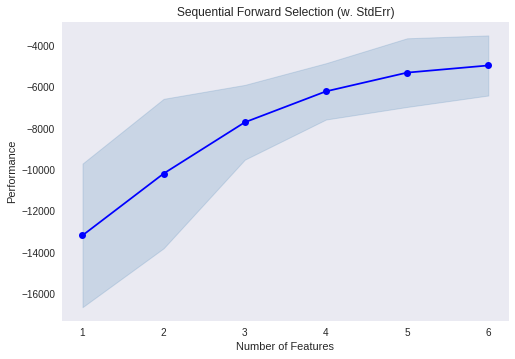

('atemp', 'weather', 'workingday', 'hour', 'year', 'month')


In [24]:
fig = plot_sfs(SFS.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

print(SFS.k_feature_names_)

In [25]:
rf_sfs = RandomForestRegressor(n_estimators = 100, max_depth = 50, oob_score = False, n_jobs = -1)
SFS_b = SequentialFeatureSelector(rf_sfs, forward=False, k_features=6, scoring='mean_squared_error', verbose=1, n_jobs=-1)
SFS_b = SFS_b.fit(X_train.values,Y_train.values)

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  1.3min finished
Features: 10/6[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished
Features: 9/6[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   54.0s finished
Features: 8/6[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   39.6s finished
Features: 7/6[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   34.3s finished
Features: 6/6

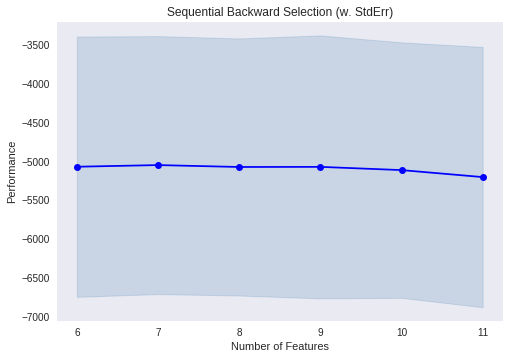



{('0', 'atemp'), ('8', 'weather'), ('7', 'season'), ('2', 'holiday'), ('6', 'humidity'), ('10', 'windspeed')}


In [26]:
fig = plot_sfs(SFS_b.get_metric_dict(), kind='std_err')

plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

print('\n')
indxs = list(SFS_b.k_feature_names_)
str_cols = X_train.columns
features = set(zip(indxs,str_cols))
print(features)

In [0]:
rf_fil = RandomForestRegressor(n_estimators = 100, max_depth = 50, oob_score = False, n_jobs = -1)
common_features = ['humidity','weather','season','atemp','workingday','hour','year','month']
X_train_filtered = X_train[common_features]
X_test_filtered = X_test[common_features]

# X_train_fil_scaled = scaler.fit_transform(X_train_filtered)
# X_test_fil_scaled = scaler.fit_transform(X_test_filtered)

In [0]:
rf_fil.fit(X_train_filtered,Y_train)
model_stats(rf_fil,'Filtered & Scaled Features RF', X_train_filtered, Y_train, X_test_filtered, Y_test)

In [29]:
error_metric

,Model,Testing RMSLE,Testing R^2,Training RMSLE,Training R^2
0,Tuned RF Model,0.361795,0.862357,0.164994,0.990561
0,Scaled & Tuned RF,0.100787,0.591306,0.011758,0.992381
0,Boruta Features RF,0.343886,0.879993,0.153231,0.992460
0,Filtered & Scaled Features RF,0.370061,0.868669,0.168637,0.990460
